This notebook creates three example maps for Burkina Faso, with all rivers stratified by Degree of Regulation, (1) all current rivers and protected areas, (2) all current rivers that overlap protected areas, and (3) all projected future rivers that overlap protected areas.

In [1]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import earthpy as et
import earthpy.plot as ep
import contextily as ctx

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [3]:
# Download Data stored on figshare
# Free flowing rivers current DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273213")

# Free flowing rivers future DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273216")

# World Database of Protected Areas - split by continent
et.data.get_data(url="https://ndownloader.figshare.com/files/23354894")

# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

# Continent boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")

# Continent-country csv
et.data.get_data(url="https://ndownloader.figshare.com/files/23393756")

'/home/jovyan/earth-analytics/data/earthpy-downloads/continent-country.csv'

In [4]:
# Custon Function
def all_pa_country(wdpa_polys, ramsar_polys, country_name):
    """ This function takes a country name, WDPA polygons, and Ramsar Polygons, and returns a multipolygon feature of 
    the World Database of Protected Areas merged with the ramsar areas for that country.

    Parameters
    ----------
    country_name: str
        Three letter country code for the country to be analyzed.
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected country.
    ramsar_polys: gdf
        The feature with the ramsar polygons for the selected country.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the country.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["PARENT_ISO"] == country_name]
    wdpa_polys = wdpa_polys[wdpa_polys["PARENT_ISO"] == country_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [5]:
# Custon Function
def all_pa_continent(wdpa_polys, ramsar_polys, cont_name):
    """ This function takes WDPA polygons for a continent and global ramsar polygons and returns a multipolygon feature 
    of the World Database of Protected Areas merged with the ramsar areas for that continent.

    Parameters
    ----------
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected continent.
    ramsar_polys: gdf
        The feature with all global ramsar polygons.
    cont_name: str
        The name of the selected continent.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the continent.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["continent"] == cont_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [6]:
# Open continent & country borders & ISOs
country_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "country-borders",
                                             "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"))

continent_iso = pd.read_csv(os.path.join(wd_path, "earthpy-downloads",
                                         "continent-country.csv"))

continent_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "continent-poly",
                                               "Continents.shp"))

# Reproject data to World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
country_borders = country_borders.to_crs('epsg:4087')
continent_borders = continent_borders.to_crs('epsg:4087')

In [7]:
# Open ramsar areas
ramsar_polys = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Rename ramsar columns to match WDPA
try:
    ramsar_polys = ramsar_polys.rename(
        columns={"iso3": "PARENT_ISO", "officialna": "NAME", "area_off": "Shape_Area"})
except:
    print('Ramsar column names already match WDPA dataset.')

# Merge continent names with ramsar data for analyzing by continent
ramsar_polys = pd.merge(ramsar_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

# Data cleaning - take only necessary ramsar columns
ramsar_polys = ramsar_polys[['NAME', 'PARENT_ISO',
                             'Shape_Area', 'continent', 'geometry']]

# Reproject ramsar data to  World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
ramsar_polys = ramsar_polys.to_crs('epsg:4087')

In [20]:
# Open current DOR shapefiles
dor_0to5 = gpd.read_file(os.path.join(wd_path,
                                      "earthpy-downloads", "DOR_Binned", "DOR_0to5.shp"))
dor_5to10 = gpd.read_file(os.path.join(wd_path,
                                       "earthpy-downloads", "DOR_Binned", "DOR_5to10.shp"))
dor_10to15 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_10to15.shp"))
dor_15to20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_15to20.shp"))
dor_over20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_over20.shp"))

# Open planned DOR shapefiles
dor_pla_0to5 = gpd.read_file(os.path.join(wd_path,
                                          "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_0to5.shp"))
dor_pla_5to10 = gpd.read_file(os.path.join(wd_path,
                                           "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_5to10.shp"))
dor_pla_10to15 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_10to15.shp"))
dor_pla_15to20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_15to20.shp"))
dor_pla_over20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_over20.shp"))

In [9]:
# Get all current rivers in selected continent
all_rivers_0to5_africa = dor_0to5[dor_0to5['CONTINENT'] == "Africa"]
all_rivers_5to10_africa = dor_5to10[dor_5to10['CONTINENT'] == "Africa"]
all_rivers_10to15_africa = dor_10to15[dor_10to15['CONTINENT'] == "Africa"]
all_rivers_15to20_africa = dor_15to20[dor_15to20['CONTINENT'] == "Africa"]
all_rivers_over20_africa = dor_over20[dor_over20['CONTINENT'] == "Africa"]

# Get all current rivers in selected continent
all_rivers_pla_0to5_africa = dor_pla_0to5[dor_pla_0to5['CONTINENT'] == "Africa"]
all_rivers_pla_5to10_africa = dor_pla_5to10[dor_pla_5to10['CONTINENT'] == "Africa"]
all_rivers_pla_10to15_africa = dor_pla_10to15[dor_pla_10to15['CONTINENT'] == "Africa"]
all_rivers_pla_15to20_africa = dor_pla_15to20[dor_pla_15to20['CONTINENT'] == "Africa"]
all_rivers_pla_over20_africa = dor_pla_over20[dor_pla_over20['CONTINENT'] == "Africa"]

# Get all current rivers in selected country
all_rivers_0to5_bfa = dor_0to5[dor_0to5['ISO_NAME'] == "Burkina Faso"]
all_rivers_5to10_bfa = dor_5to10[dor_5to10['ISO_NAME'] == "Burkina Faso"]
all_rivers_10to15_bfa = dor_10to15[dor_10to15['ISO_NAME'] == "Burkina Faso"]
all_rivers_15to20_bfa = dor_15to20[dor_15to20['ISO_NAME'] == "Burkina Faso"]
all_rivers_over20_bfa = dor_over20[dor_over20['ISO_NAME'] == "Burkina Faso"]

In [21]:
# For loop to (1) calculating difference in DOR between planned and current, (2) pulling only rivers with class > 3,
# (3) projecting rivers, (4) buffer by 1/100 km to become polys for overlay fuction, (5) pull only needed columns

gdf_list = [all_rivers_0to5_africa, all_rivers_5to10_africa, all_rivers_10to15_africa, all_rivers_15to20_africa, all_rivers_over20_africa,
            all_rivers_pla_0to5_africa, all_rivers_pla_5to10_africa, all_rivers_pla_10to15_africa, all_rivers_pla_15to20_africa, all_rivers_pla_over20_africa]
river_list_prj = []

for shp in gdf_list:
    shp['DOR_DIFF'] = shp['DOR_PLA'] - shp['DOR']
#    shp = shp[shp.RIV_CLASS > 3] # not filtering to show only large rivers since that makes the maps too boring!
    shp = shp.to_crs('epsg:4087')
    shp['geometry'] = shp.buffer(100)
    shp = shp[['LENGTH_KM', 'RIV_ORD', 'RIV_CLASS', 'CONTINENT',
               'ISO_NAME', 'BAS_NAME', 'DOR', 'DOR_PLA', 'DOR_DIFF', 'Shape_Leng', 'geometry']]
    river_list_prj.append(shp)

# Re-assign names based on list index
dor_0to5 = river_list_prj[0]
dor_5to10 = river_list_prj[1]
dor_10to15 = river_list_prj[2]
dor_15to20 = river_list_prj[3]
dor_over20 = river_list_prj[4]

dor_pla_0to5 = river_list_prj[5]
dor_pla_5to10 = river_list_prj[6]
dor_pla_10to15 = river_list_prj[7]
dor_pla_15to20 = river_list_prj[8]
dor_pla_over20 = river_list_prj[9]

# Concatanate all rivers gdfs for easier analysis later
all_rivers = pd.concat([dor_0to5, dor_5to10, dor_10to15,
                        dor_15to20, dor_over20], axis=0)

# Remove rivers that have DOR_DIFF of 0
all_rivers_lg = all_rivers[all_rivers.DOR_DIFF > 0]

In [11]:
# Analyze Africa
wdpa_africa_polys = gpd.read_file(os.path.join(wd_path,
                                               "earthpy-downloads", "WDPA_Africa", "WDPA_Africa.shp"))

# Data cleaning - remove polygons with no area & take only the needed columns from WDPA dataset
wdpa_africa_polys = wdpa_africa_polys[wdpa_africa_polys.geometry != None]

# Merge continent africames with WDPA data for aafricalyzing by continent
wdpa_africa_polys = pd.merge(wdpa_africa_polys, continent_iso,
                             left_on='PARENT_ISO', right_on='ISO3')

# Take only the columns we need
wdpa_africa_polys = wdpa_africa_polys[[
    'NAME', 'DESIG', 'PARENT_ISO', 'GIS_AREA', 'continent', 'geometry']]

# Reporject WDPA data
wdpa_africa_polys = wdpa_africa_polys.to_crs('epsg:4087')

# Get the combined WDPA & ramsar areas for selected continent
wdpa_ramsar_africa = all_pa_continent(
    wdpa_africa_polys, ramsar_polys, "Africa")

# Getting river length affected
# Overlay current rivers on protected areas for selected continent to get ONLY rivers the overlap PAs
river_overlap_africa = gpd.overlay(
    wdpa_ramsar_africa, all_rivers_lg, how='intersection')

# Getting protected areas affected
# Overlay projected rivers on pas for selected continent to get ONLY pas that overlap rivers
pa_overlap_africa = gpd.overlay(
    river_overlap_africa, wdpa_ramsar_africa, how='intersection')

# Get a list of countries in each continent for calculating lengths/areas by country later
africa_countries = continent_iso[continent_iso.continent == 'Africa']

# Create empty lists
country_sums = []
area_sums = []
countries = []

# Sum up the total river length affected by country in the continent
for country in africa_countries.ISO3:
    country_sums.append((
        river_overlap_africa.loc[river_overlap_africa['PARENT_ISO'] == country, 'LENGTH_KM'].sum()).round(0))
    area_sums.append((
        pa_overlap_africa.loc[pa_overlap_africa['PARENT_ISO_1'] == country, 'Shape_Area_1'].sum()).round(0))
    countries.append(country)

 # Create a pandas dataframe of lengths and areas affected
africa_affected = pd.DataFrame(list(zip(countries, country_sums, area_sums)), columns=[
    'Country', 'Affected_KM', 'Affected_Area'])

In [12]:
# Get all current rivers in selected country & buffer to look nicer on map
all_rivers_0to5_bfa = (
    dor_0to5[dor_0to5['ISO_NAME'] == "Burkina Faso"]).buffer(1000)
all_rivers_5to10_bfa = (
    dor_5to10[dor_5to10['ISO_NAME'] == "Burkina Faso"]).buffer(1000)
all_rivers_10to15_bfa = (
    dor_10to15[dor_10to15['ISO_NAME'] == "Burkina Faso"]).buffer(1000)
all_rivers_15to20_bfa = (
    dor_15to20[dor_15to20['ISO_NAME'] == "Burkina Faso"]).buffer(1000)
all_rivers_over20_bfa = (
    dor_over20[dor_over20['ISO_NAME'] == "Burkina Faso"]).buffer(1000)

In [13]:
# Get the combined WDPA & ramsar areas for seleced country for plotting
wdpa_ramsar_bfa = all_pa_country(wdpa_africa_polys, ramsar_polys, 'BFA')

# Overlay current rivers on protected areas for selected country & buffer to look nicer on map
rivers_0to5_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_0to5, how='intersection').buffer(1000))
rivers_5to10_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_5to10, how='intersection').buffer(1000))
rivers_10to15_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_10to15, how='intersection').buffer(1000))
rivers_15to20_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_15to20, how='intersection').buffer(1000))
rivers_over20_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_over20, how='intersection').buffer(1000))

# Overlay proposed rivers on protected areas for selected country & buffer to look nicer on map
rivers_pla_0to5_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_pla_0to5, how='intersection').buffer(1000))
rivers_pla_5to10_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_pla_5to10, how='intersection').buffer(1000))
rivers_pla_10to15_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_pla_10to15, how='intersection').buffer(1000))
rivers_pla_15to20_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_pla_15to20, how='intersection').buffer(1000))
rivers_pla_over20_bfa = (gpd.overlay(
    wdpa_ramsar_bfa, dor_pla_over20, how='intersection').buffer(1000))

No ramsar areas in WDPA dataset.
No duplicates in the WDPA dataset.


In [14]:
# Get country border for plotting
bfa_border = country_borders[country_borders['CNTRY_NAME'] == "Burkina Faso"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  del sys.path[0]


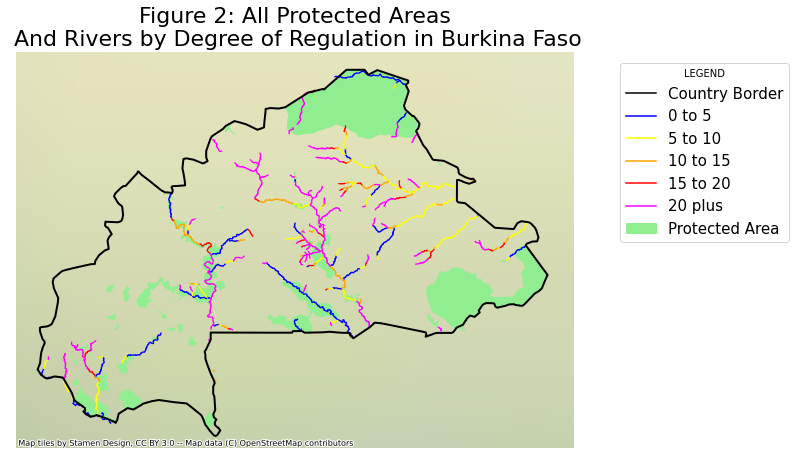

In [18]:
# Plot all rivers and all protected areas for selected country
# Create legend
black_line = mlines.Line2D([], [], color='black', label='Country Border')
blue_line = mlines.Line2D([], [], color='blue', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')

fig, ax = plt.subplots(figsize=(10, 10))
wdpa_ramsar_bfa.plot(ax=ax, color="lightgreen")
all_rivers_0to5_bfa.plot(ax=ax,
                         color='blue')
all_rivers_5to10_bfa.plot(ax=ax,
                          color='yellow')
all_rivers_10to15_bfa.plot(ax=ax,
                           color='orange')
all_rivers_15to20_bfa.plot(ax=ax, color='red')
all_rivers_over20_bfa.plot(ax=ax,
                           color='magenta')
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
bfa_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
ax.set_title(
    'Figure 1: All Protected Areas\n And Rivers by Degree of Regulation in Burkina Faso', size=22)
ax.set_axis_off()
ax.legend(handles=[black_line, blue_line, yellow_line, orange_line, red_line, magenta_line, lightgreen_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'), bbox_to_anchor=(1.4, .5),
          title="LEGEND")

In [1]:
# Plot all current rivers and that overlap protected areas for selected country
# Adding a title to the whole figure
fig.suptitle(
    "All Current & Planned Rivers Overlapping Protected Areas \n in Burkina Faso by Degree of Regulation (DOR)", fontsize=22)

# Defining plot space
fig, ax1 = plt.subplots(figsize=(10, 10))
wdpa_ramsar_bfa.plot(ax=ax1, color="lightgreen")
rivers_0to5_bfa.plot(ax=ax1,
                     color='blue')
rivers_5to10_bfa.plot(ax=ax1,
                      color='yellow')
rivers_10to15_bfa.plot(ax=ax1,
                       color='orange')
rivers_15to20_bfa.plot(ax=ax1, color='red')
rivers_over20_bfa.plot(ax=ax1,
                       color='magenta')
ctx.add_basemap(ax1, url=ctx.providers.Stamen.Terrain, zoom=0)
bfa_border.plot(ax=ax1, color="none",  edgecolor="black", linewidth=2)
ax1.set_title(
    'Figure 2: Current Rivers DOR', size=18)
ax1.set_axis_off()

# Plot all planned rivers and that overlap protected areas for selected country
fig, ax2 = plt.subplots(figsize=(10, 10))
wdpa_ramsar_bfa.plot(ax=ax2, color="lightgreen")
wdpa_ramsar_bfa.plot(ax=ax2, color="lightgreen")
rivers_pla_0to5_bfa.plot(ax=ax2,
                         color='blue')
rivers_pla_5to10_bfa.plot(ax=ax2,
                          color='yellow')
rivers_pla_10to15_bfa.plot(ax=ax2,
                           color='orange')
rivers_pla_15to20_bfa.plot(ax=ax2, color='red')
rivers_pla_over20_bfa.plot(ax=ax2,
                           color='magenta')
ctx.add_basemap(ax2, url=ctx.providers.Stamen.Terrain, zoom=0)
bfa_border.plot(ax=ax2, color="none",  edgecolor="black", linewidth=2)
ax2.set_title(
    'Figure 3: Planned Rivers DOR', size=18)
ax2.set_axis_off()
ax2.text(0.5, -0.2, "Data Sources: Free Flowing Rivers Dataset World Database of Protected Areas Ramsar Areas",
         size=12, ha="center", transform=ax2.transAxes)
ax2.legend(handles=[black_line, blue_line, yellow_line, orange_line, red_line, magenta_line, lightgreen_patch],
           fontsize=15,
           frameon=True,
           loc='lower right',
           title="LEGEND")

NameError: name 'fig' is not defined